## See Click Predict Fix

This project was conducted to analyze and predict 311 issues received from the SeeClickFix platform. 311 is a mechanism that allows citizens to raise issues with their city or government. In this project, we aimed to predict the number of views, votes, and comments a specific 311 issue receives. These predictions provide important information to help governments focus on the most pressing issues.

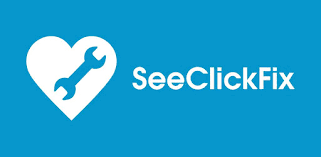

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/see-click-predict-fix/sampleSubmission.csv
/kaggle/input/see-click-predict-fix/train.csv
/kaggle/input/see-click-predict-fix/test.csv


## Import Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
train=pd.read_csv('/kaggle/input/see-click-predict-fix/train.csv')
test=pd.read_csv('/kaggle/input/see-click-predict-fix/test.csv')

## EDA

In [5]:
train.head()

,id,latitude,longitude,summary,description,num_votes,num_comments,num_views,source,created_time,tag_type
0,368683,37.590139,-77.456841,Alleyway light out.,There is a streetlight lamp out in the alleywa...,4,0,62,New Map Widget,2012-01-01 01:20:08,street_light
1,77642,37.541534,-77.451985,brick side walk has sink hole,bricks are falling into deep hole. please rep...,2,2,28,NaN,2012-01-01 03:18:40,pothole
2,335652,37.560369,-77.468661,Graffiti,This is the rear parking lot of the former Jul...,4,2,36,New Map Widget,2012-01-01 03:39:48,graffiti
3,339096,37.553762,-77.474736,Non-functioning Traffic Lights,Walking man out on nb side of blvd southward w...,2,0,29,android,2012-01-01 13:59:41,traffic
4,343122,37.538814,-77.437136,Pothole in Crosswalk,Going from South to North in front of Wells Fa...,2,0,18,New Map Widget,2012-01-01 14:05:30,pothole


In [6]:
test.head()

,id,latitude,longitude,summary,description,source,created_time,tag_type
0,21523,41.913652,-87.706050,Graffiti Removal,NaN,remote_api_created,2013-05-01 00:13:47,NaN
1,87152,41.913646,-87.706479,Graffiti Removal,NaN,remote_api_created,2013-05-01 00:14:57,NaN
2,182789,41.992691,-87.663184,Graffiti Removal,NaN,remote_api_created,2013-05-01 00:18:49,NaN
3,312571,41.702686,-87.525743,Traffic Signal Out,Assigned to Traffic Signal Repairman,remote_api_created,2013-05-01 00:18:49,NaN
4,246776,41.724424,-87.643293,Street Light 1 / Out,NaN,remote_api_created,2013-05-01 00:25:40,NaN


In [7]:
train.shape, test.shape

((223129, 11), (149575, 8))

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223129 entries, 0 to 223128
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            223129 non-null  int64  
 1   latitude      223129 non-null  float64
 2   longitude     223129 non-null  float64
 3   summary       223129 non-null  object 
 4   description   106819 non-null  object 
 5   num_votes     223129 non-null  int64  
 6   num_comments  223129 non-null  int64  
 7   num_views     223129 non-null  int64  
 8   source        194278 non-null  object 
 9   created_time  223129 non-null  object 
 10  tag_type      53415 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 18.7+ MB


In [9]:
train.isnull().sum()

id                   0
latitude             0
longitude            0
summary              0
description     116310
num_votes            0
num_comments         0
num_views            0
source           28851
created_time         0
tag_type        169714
dtype: int64

In [11]:
train.drop('id', axis=1 ,inplace=True)

In [12]:
train.head()

,latitude,longitude,summary,description,num_votes,num_comments,num_views,source,created_time,tag_type
0,37.590139,-77.456841,Alleyway light out.,There is a streetlight lamp out in the alleywa...,4,0,62,New Map Widget,2012-01-01 01:20:08,street_light
1,37.541534,-77.451985,brick side walk has sink hole,bricks are falling into deep hole. please rep...,2,2,28,NaN,2012-01-01 03:18:40,pothole
2,37.560369,-77.468661,Graffiti,This is the rear parking lot of the former Jul...,4,2,36,New Map Widget,2012-01-01 03:39:48,graffiti
3,37.553762,-77.474736,Non-functioning Traffic Lights,Walking man out on nb side of blvd southward w...,2,0,29,android,2012-01-01 13:59:41,traffic
4,37.538814,-77.437136,Pothole in Crosswalk,Going from South to North in front of Wells Fa...,2,0,18,New Map Widget,2012-01-01 14:05:30,pothole


In [13]:
train=train.dropna()

In [14]:
train['summary']

0                    Alleyway light out.
2                               Graffiti
3         Non-functioning Traffic Lights
4                   Pothole in Crosswalk
5         Street Light Out near Bus Stop
                       ...              
223085                          Graffiti
223089                   Illegal Dumping
223090                          Graffiti
223097                          Potholes
223115           pothole broken pavement
Name: summary, Length: 29194, dtype: object

In [15]:
def clean_text(df, columns):
    for column in columns:
        df[column] = df[column].str.lower()
        df[column] = df[column].str.replace("[^\w\s]", "", regex=True)
        df[column] = df[column].str.replace('[\n]', '', regex=True)
        df[column] = df[column].str.replace('\d+', '', regex=True)
        df[column] = df[column].str.replace('\r', ' ', regex=True)
    return df

# Temizleme işlemini uygulama
columns_to_clean = ['summary','description','source','tag_type'] 
train = clean_text(train, columns_to_clean)
test = clean_text(test, columns_to_clean)

#I put it in a function because there are multiple columns to clear

## Data Visualization

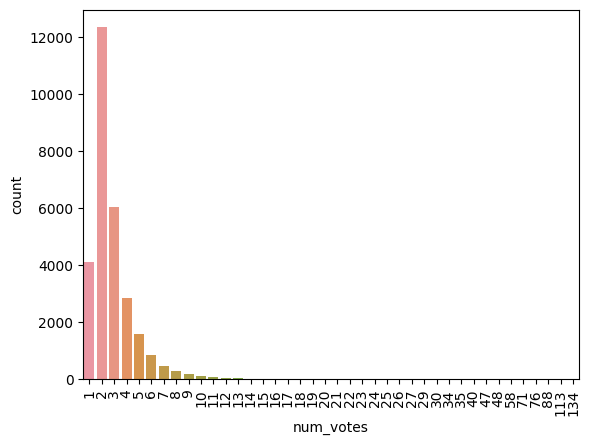

In [16]:
sns.countplot(x=train['num_votes'])
plt.xticks(rotation=90);

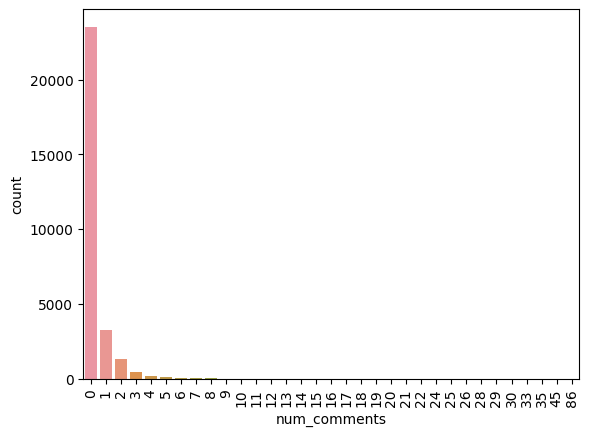

In [17]:
sns.countplot(x=train['num_comments'])
plt.xticks(rotation=90);

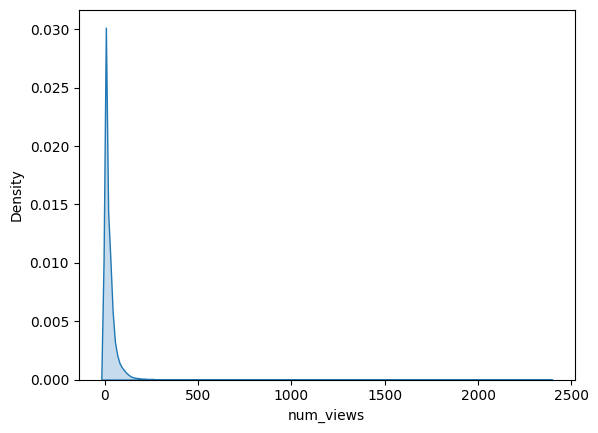

In [18]:
sns.kdeplot(x=train['num_views'], fill=True);

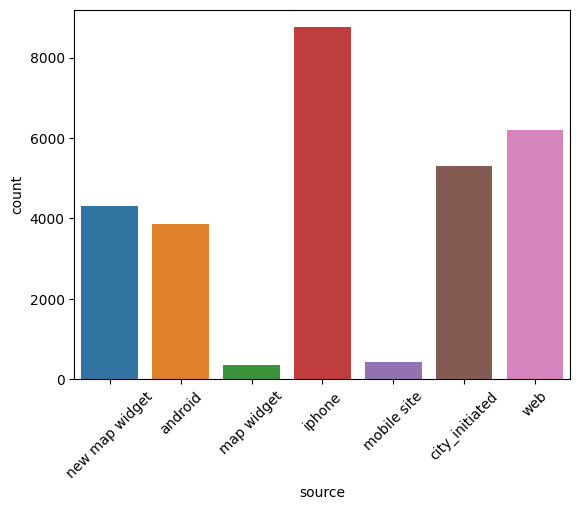

In [19]:
sns.countplot(x=train['source'])
plt.xticks(rotation=45);

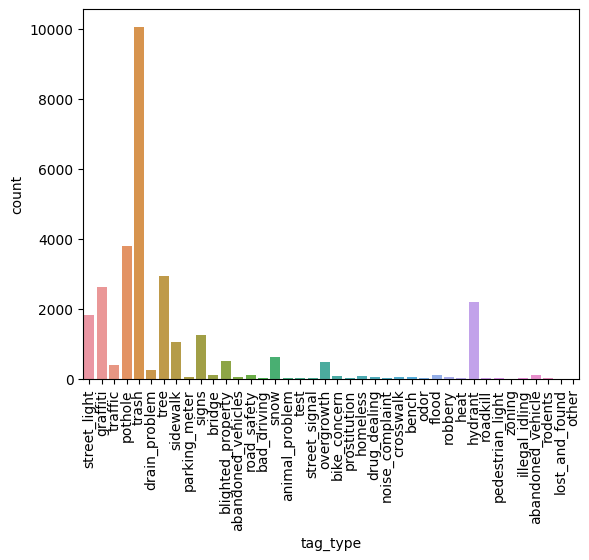

In [20]:
sns.countplot(x=train['tag_type'])
plt.xticks(rotation=90);

## Modelling

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split

In [22]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from textblob import TextBlob

In [23]:
from nltk.stem import PorterStemmer
pr=PorterStemmer()

In [24]:
# num_views,num_votes,num_comments
#Values to be estimated

In [25]:
train.isnull().sum()

latitude        0
longitude       0
summary         0
description     0
num_votes       0
num_comments    0
num_views       0
source          0
created_time    0
tag_type        0
dtype: int64

In [26]:
def lemmafn(text):
    words=TextBlob(text).words
    return [pr.stem(word) for word in words]

In [27]:
vect=CountVectorizer()

In [28]:
train.head()

,latitude,longitude,summary,description,num_votes,num_comments,num_views,source,created_time,tag_type
0,37.590139,-77.456841,alleyway light out,there is a streetlight lamp out in the alleywa...,4,0,62,new map widget,2012-01-01 01:20:08,street_light
2,37.560369,-77.468661,graffiti,this is the rear parking lot of the former jul...,4,2,36,new map widget,2012-01-01 03:39:48,graffiti
3,37.553762,-77.474736,nonfunctioning traffic lights,walking man out on nb side of blvd southward w...,2,0,29,android,2012-01-01 13:59:41,traffic
4,37.538814,-77.437136,pothole in crosswalk,going from south to north in front of wells fa...,2,0,18,new map widget,2012-01-01 14:05:30,pothole
5,37.538814,-77.437136,street light out near bus stop,on west side of street between main and frankl...,2,0,17,new map widget,2012-01-01 14:07:06,street_light


In [29]:
x_combined = train['summary'] + ' ' + train['description'] + ' ' + train['source'] + ' ' + train['tag_type']
#If I don't add the fit transform columns that I will give to x like this, it gives an error below.

In [30]:
x=x_combined
y=train[['num_votes','num_comments','num_views']]

In [31]:
x.shape

(29194,)

In [32]:
y.shape

(29194, 3)

In [33]:
x=vect.fit_transform(x)

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.20)

In [35]:
model = MultiOutputRegressor(RandomForestRegressor())
model.fit(x_train, y_train)

lpred = model.predict(x_test)

# Calculating RMSLE
def rmsle(y_true, y_pred):
    # When taking logarithms it is important to include a check for values ​​less than zero
    y_true_log = np.log1p(y_true)  # log(1 + y_true)
    y_pred_log = np.log1p(y_pred)  # log(1 + y_pred)
    return np.sqrt(np.mean((y_true_log - y_pred_log) ** 2))

# Calculate RMSLE for each target variable
for i in range(y_test.shape[1]):
    score = rmsle(y_test.iloc[:, i], lpred[:, i])
    print(f"RMSLE for target {i}: {score}")
        
#Since this project was multioutput, we did not calculate accuracy or r2. We only calculated RMSLE. This was what was requested in the competition.

RMSLE for target 0: 0.3390046033746642
RMSLE for target 1: 0.4334417799211018
RMSLE for target 2: 1.0645146261788752


## Summary

The provided dataset includes various features and target variables related to 311 issues. The data was read in accordance with the requirements and passed through a certain pre-processing process. Using different graphs and maps, which issues citizens are more interested in and the changes in these issues over time were analyzed.
In this project, which was considered as a multi-output regression problem, estimates were made for the target variables num_votes, num_comments and num_views. MultiOutputRegressor and RandomForestRegressor were used as models. The success rate was not calculated because the project was evaluated with RMSLE (Root Mean Squared Logarithmic Error).
RMSLE was calculated by taking the square root of the logarithmic differences between the estimated and actual values. This metric was used specifically to evaluate the accuracy of the estimates.
Throughout the project, important findings were obtained regarding the analysis and estimation of the data. The estimation results provided information that would help administrations determine which issues they should prioritize. The project was completed successfully by achieving the desired goals in the competition.